# Section 1: Preamble & Reading of the CSV

In [31]:
# This preamble block will ensure that we have everything we need to do our work
# moving forward in this notebook

%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [43]:
# This will load in our dataset from an uploaded file
spotify=pd.read_csv('SpotifyCleanV3.csv',
                    parse_dates=['year'])

# Section 2: The Models


# **I. Wrangle Data**

In [44]:
# This will define a wrangle function to clean and engineer our data
def wrangle(X):
  X = X.copy()

# This will drop the "popularity" column, since that is directly related to our
# prediction of "popularity_class" and we want to avoid leakage
  X = X.drop('popularity', axis=1)

# This will wash out any NaN values within the set
  X = X.dropna()

# This will engineer two new features, length of the performer and name of the 
# track
  X['song_name_length'] = X['name'].str.len()
  X['artist_name_length'] = X['artists'].str.len()

# This will engineer a new feature, the year of the track's release
  X['release_year'] = X['year'].dt.year

# This will drop the two string columns, "artists" & "name", since they will 
# interfere with our model later, but hopefully provide some insight with their
# length, which we engineered above
  X = X.drop(['artists', 'name'], axis=1)

# This will set the index for our dataframe to the "year" column, which is
# date of release
  X = X.set_index('year')

# This will return our modified dataframe
  return X

In [45]:
# This will pass our raw file through our newly created function and return to
# us our modified dataframe to work with
spotify = wrangle(spotify)

# **II. Split Data**

In [5]:
# This will split our data into train and test subsets, consisting of 80% and 20%
# of the original set, respectively
train, test = train_test_split(spotify, train_size=0.80, test_size=0.20, random_state=42)

In [6]:
# This will further split our train subset into training data and validation data,
# which results in the train, validation, and test sets now consisting of 60%,
# 20% and 20% of the original set
train, val = train_test_split(train, train_size=0.75, test_size=0.20, random_state=42)

In [7]:
# The goal of the model is to predict "popularity_class", so we separate our
# feature matrix from our target vector accordingly with this step
target = 'popularity_class'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

# **III. Establish Baseline**

In [8]:
# This returns our baseline accuracy score for our set
print("Baseline Accuracy Score:", y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.38475471698113206


# **IV. Build Models**

In [9]:
# This will create a LogisticRegression model utilizing a pipeline, which we
# will compare to other models in a moment to see which is best to proceed with
model_lr = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                 

In [10]:
# This will create a RandomForestClassifier model utilizing a pipeline, which we
# will compare to other models in a moment to see which is best to proceed with
model_rf = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

model_rf.fit(X_train, y_train);

In [11]:
# This will create a GradientBoostingClassifier model utilizing a pipeline, which we
# will compare to other models in a moment to see which is best to proceed with
model_gb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_gb.fit(X_train, y_train);

In [12]:
# This will create a XGBClassifier model utilizing a pipeline, which we will
# compare to other models in a moment to see which is best to proceed with
model_xgb = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,
                  n_jobs=10)
)

model_xgb.fit(X_train, y_train);

# **V. Check Metrics**

In [13]:
# This will calculate the cross-validation score for the training data, which
# isn't exactly necessary for this particular assignment, but still valuable
# for our own edification
rf_cvs = cross_val_score(model_rf, X_train, y_train, cv=5, n_jobs=-1)
print(rf_cvs)

[0.67132075 0.6745283  0.67220126 0.67125786 0.67440252]


In [14]:
# This will calculate and return the training and validation accuracy for the
# logistic regression model
print('Training Accuracy:', model_lr.score(X_train, y_train))
print('Validation Accuracy:', model_lr.score(X_val, y_val))

Training Accuracy: 0.38567295597484275
Validation Accuracy: 0.3885377358490566


In [15]:
# This will calculate and return the training and validation accuracy for the
# gradient boosting model
print('Gradient Boosting Training Accuracy:', model_gb.score(X_train, y_train))
print('Gradient Boosting Validation Accuracy:', model_gb.score(X_val, y_val))

Gradient Boosting Training Accuracy: 0.6764276729559748
Gradient Boosting Validation Accuracy: 0.6698584905660377


In [16]:
# This will calculate and return the training and validation accuracy for the
# XGBoost model
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.6705408805031446
XGBoost Validation Accuracy: 0.6666981132075471


# **VI. Tune Model**

In [17]:
# This will set the parameters for our RandomizedSearch that we will conduct
# in the next block
parasect = {'randomforestclassifier__n_estimators': np.arange(20, 61, 20),
         'randomforestclassifier__max_depth': np.arange(10, 31, 10),
         'randomforestclassifier__max_samples': np.arange(0.3, 0.71, 0.2)}

In [18]:
# This will create the model for a RandomizedSearchCV utilizing the
# RandomForestClassifier model above
rf_rs = RandomizedSearchCV(model_rf, parasect, cv=5, n_jobs=-1, verbose=1)

In [19]:
# This will fit the RandomizedSearch upon training data
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=[],
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
    

In [20]:
# This will predict the values for the test data utilizing the RandomizedSearch
# model
y_pred = rf_rs.predict(X_test)

In [21]:
# This will calculate and return the accuracy for the RandomizedSearch model by
# checking the predictions against the correct values
print('RandomizedSearch Accuracy', accuracy_score(y_test, y_pred))

RandomizedSearch Accuracy 0.6732576129202672


# **VII. Communicate Results**

In [22]:
# This will create a new model, outside of a pipeline, so that we can look at
# some visualizations that don't play nice with pipeline objects
spot_boost = XGBRegressor(random_state=42)
spot_boost.fit(X_train, y_train)

[19:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
# This will assign a single row from the validation subset so we can examine
# how the features affect the model's prediction
row = X_val.iloc[[1829]]
row

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,speechiness,tempo,valence,song_name_length,artist_name_length,release_year
year,,,,,,,,,,,,,,,
1981-01-01,0.0709,0.36,426733,0.868,0,0.000909,9,0.233,-9.085,0.041,148.547,0.762,33,9,1981


In [24]:
# This will create a shapley plot for examining individual feature's affect

explainer = TreeExplainer(spot_boost)

initjs()

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(row),
    features=row
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


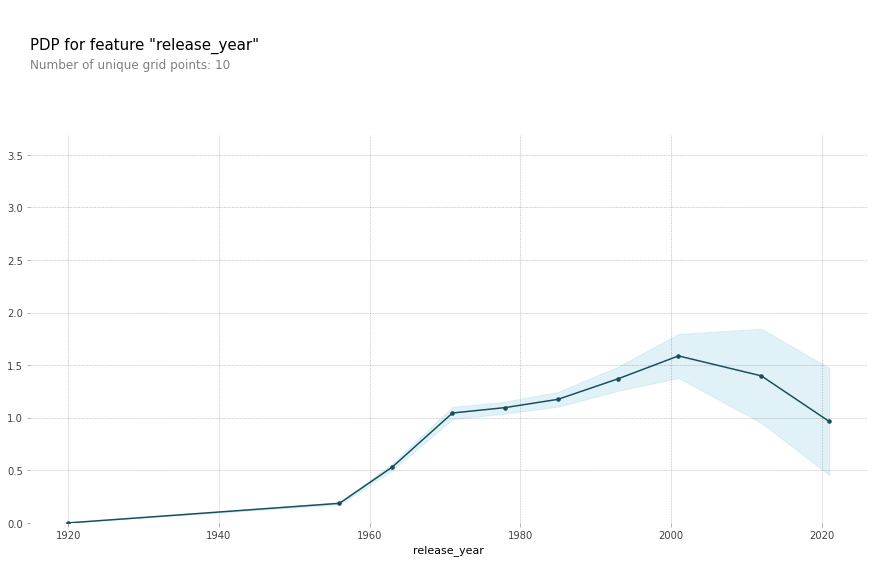

In [25]:
# This creates a visual for how the value of 'release_year' affects the
# prediction of the model
feature = 'release_year'

isolate = pdp_isolate(
    model=spot_boost,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

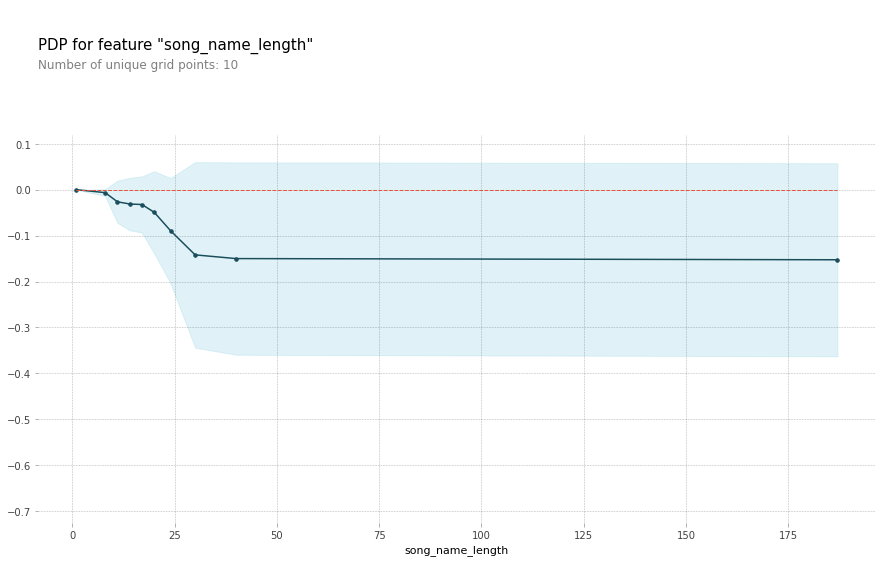

In [38]:
# This creates a visual for how the value of 'loudness' affects the
# prediction of the model
feature = 'song_name_length'

isolate = pdp_isolate(
    model=spot_boost,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

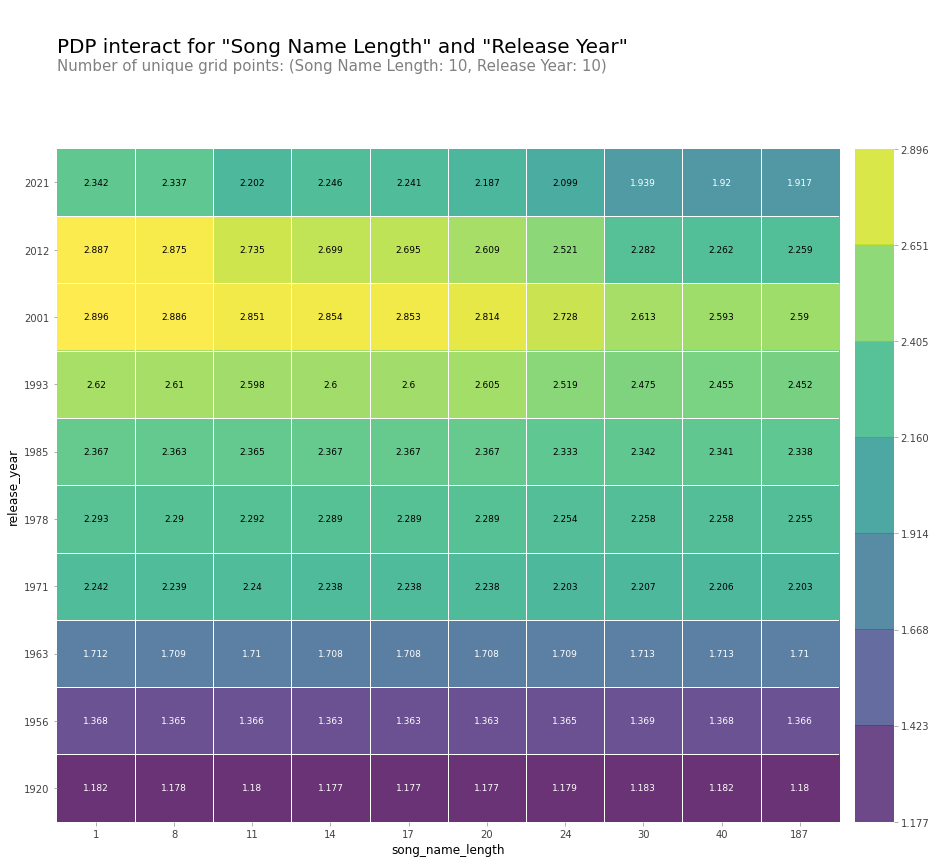

In [37]:
# This creates a PDP interact plot for the features of 'loudness'
# and 'release_year'
features = ['song_name_length', 'release_year']

interact = pdp_interact(
    model=spot_boost,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

plot_para = {
    # plot title and subtitle
    'title': 'PDP interact for "Song Name Length" and "Release Year"',
    'subtitle': 'Number of unique grid points: (Song Name Length: 10, Release Year: 10)',
    'title_fontsize': 20,
    'subtitle_fontsize': 15,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 0.8,
    # fontsize for interact plot text
    'inter_fontsize': 9,
}

pdp_interact_plot(interact, plot_type='grid', feature_names=features, figsize=(15,15), plot_params=plot_para);